# Projet 6 - Etude de faisabilité de la classification à partir des descriptions en utilisant des méthodes NLP basiques

## Préparation du dataset

In [1]:
#imports divers

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
import time
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer



# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/alexandre/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexandre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#import du fichier dans un dataframe pandas
data_text = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
#etude des colonnes du dataset
data_text.columns


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
# visualisation des colonnes intéressantes
data_text[['product_category_tree', 'description']]

,product_category_tree,description
0,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [5]:
# extraction de la catégorie du produit
data_text['label'] = data_text['product_category_tree'].str.extract(r'\[\"(.*?)>>', expand=False)

In [6]:
#compte du nombre de modalités et effectifs correspondant
data_text['label'].value_counts()

label
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [7]:
#variante 
data_text.groupby("label").count()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
label,,,,,,,,,,,,,,,
Baby Care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150
Beauty and Personal Care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150
Computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Home Decor & Festive Needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149
Home Furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
Kitchen & Dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150
Watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150


In [8]:
#sélection des colonnes intéressantes
data_text = data_text[['product_name', 'image', 'description', 'label']]

In [9]:
data_text

,product_name,image,description,label
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care


### Nettoyage du texte


In [10]:
# nettoyage rapide, minuscule, suppression caractères spéciaux, chiffres, stop words etc ..
# definition de la fonction de nettoyage
def clean_text(text):
    # Mettre en minuscule
    text = text.lower()
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Supprimer les stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

#ajout de la colonne correspondante
data_text['cleaned_description'] = data_text['description'].apply(clean_text)

In [11]:
data_text['cleaned_description']

0       key features elegance polyester multicolor abs...
1       specifications sathiyas cotton bath towel bath...
2       key features eurospa cotton terry face towel s...
3       key features santosh royal fashion cotton prin...
4       key features jaipur print cotton floral king s...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyfe large vinyl sticker rs online ube...
Name: cleaned_description, Length: 1050, dtype: object

### Stemming

In [12]:
# réduction des mots à leur racine
# définition fonction de stemming
def stemming(text):
    stemmer = PorterStemmer()
    stemmed_text = ' '.join([stemmer.stem(word) for word in text.split()])
    return stemmed_text

#ajout de la colonne correspondante
data_text['stemmed_description'] = data_text['cleaned_description'].apply(stemming)

In [13]:
data_text['stemmed_description']

0       key featur eleg polyest multicolor abstract ey...
1       specif sathiya cotton bath towel bath towel re...
2       key featur eurospa cotton terri face towel set...
3       key featur santosh royal fashion cotton print ...
4       key featur jaipur print cotton floral king siz...
                              ...                        
1045    oren empow extra larg self adhes sticker pack ...
1046    wallmantra larg vinyl sticker sticker pack pri...
1047    buy uberlyf extra larg pigment polyvinyl film ...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyf larg vinyl sticker rs onlin uberly...
Name: stemmed_description, Length: 1050, dtype: object

### Lemmatization

In [14]:
# réduction des mots à leurs forme canonique
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return lemmatized_text

# ajout de la colonne correspondante
data_text['lemmatized_description'] = data_text['cleaned_description'].apply(lemmatization)

In [15]:
data_text['lemmatized_description']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker r ...
1049    buy uberlyfe large vinyl sticker r online uber...
Name: lemmatized_description, Length: 1050, dtype: object

### Analyse rapide des traitements appliqués

In [16]:
# Comparaison du nombre de mots uniques
unique_stemmed = len(set(' '.join(data_text['stemmed_description']).split()))
unique_lemmatized = len(set(' '.join(data_text['lemmatized_description']).split()))

print(f"Nombre de mots uniques après stemming: {unique_stemmed}")
print(f"Nombre de mots uniques après lemmatisation: {unique_lemmatized}")

Nombre de mots uniques après stemming: 4583
Nombre de mots uniques après lemmatisation: 5147


In [17]:
data_text

,product_name,image,description,label,cleaned_description,stemmed_description,lemmatized_description
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,key featur eleg polyest multicolor abstract ey...,key feature elegance polyester multicolor abst...
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel bath...,specif sathiya cotton bath towel bath towel re...,specification sathiyas cotton bath towel bath ...
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features eurospa cotton terry face towel s...,key featur eurospa cotton terri face towel set...,key feature eurospa cotton terry face towel se...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features santosh royal fashion cotton prin...,key featur santosh royal fashion cotton print ...,key feature santosh royal fashion cotton print...
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features jaipur print cotton floral king s...,key featur jaipur print cotton floral king siz...,key feature jaipur print cotton floral king si...
...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care,oren empower extra large self adhesive sticker...,oren empow extra larg self adhes sticker pack ...,oren empower extra large self adhesive sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Baby Care,wallmantra large vinyl sticker sticker pack pr...,wallmantra larg vinyl sticker sticker pack pri...,wallmantra large vinyl sticker sticker pack pr...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Baby Care,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyf extra larg pigment polyvinyl film ...,buy uberlyfe extra large pigmented polyvinyl f...
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Baby Care,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker r ...


### Exploration visuelle des données 

In [18]:
def display_info_and_image(row, image_folder='data/Images'):
    # Construire le chemin complet de l'image
    image_path = os.path.join(image_folder, row['image'])
    
    # Vérifier si le fichier existe
    if os.path.exists(image_path):
        # Charger et afficher l'image
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')  # Masquer les axes
        plt.title(f"Label: {row['label']}")
        plt.show()
        
        # Afficher les informations
        print(f"Product: {row['description']}")
        print(f"Label: {row['label']}")
        print(f"Cleaned Description: {row['cleaned_description']}")
        print(f"Stemmed Description: {row['stemmed_description']}")
        print(f"Lemmatized Description: {row['lemmatized_description']}")
    else:
        print(f"L'image {image_path} n'existe pas.")


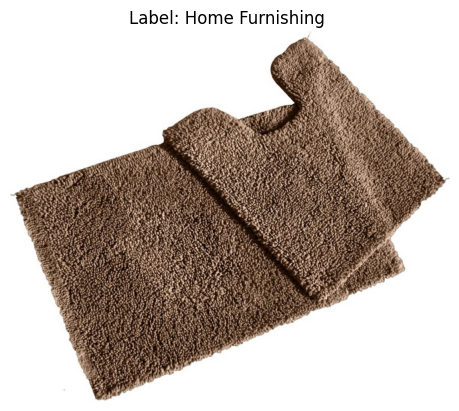

Product: Buy Riva Carpets Cotton Free Bath Mat Classic Loop Shag Bathmat_RI-527 at Rs. 1799 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!
Label: Home Furnishing 
Cleaned Description: buy riva carpets cotton free bath mat classic loop shag bathmatri rs flipkartcom genuine products free shipping cash delivery
Stemmed Description: buy riva carpet cotton free bath mat classic loop shag bathmatri rs flipkartcom genuin product free ship cash deliveri
Lemmatized Description: buy riva carpet cotton free bath mat classic loop shag bathmatri r flipkartcom genuine product free shipping cash delivery


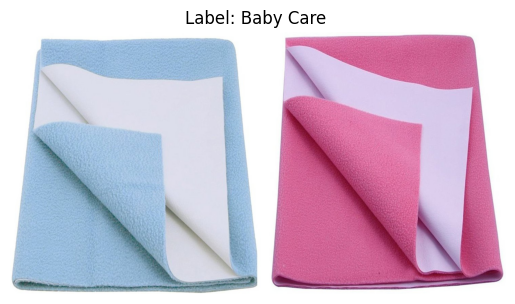

Product: Specifications of CHHOTE JANAB COZY MATTRESS PROTECTOR(SET OF 2) (MULTI) Baby Mattress Features Material COTTON General Brand CHHOTE JANAB Type WATERPROOF Model Name COZY MATTRESS PROTECTOR(SET OF 2) Pattern PLAIN Model ID ED104 Color MULTI Additional Features SOFT AND COMFORTABLE, WATERPROOF, SET OF 2, COLOUR MAY BE VARY. In the Box Sales Package 2 MATTRESS
Label: Baby Care 
Cleaned Description: specifications chhote janab cozy mattress protectorset multi baby mattress features material cotton general brand chhote janab type waterproof model name cozy mattress protectorset pattern plain model id ed color multi additional features soft comfortable waterproof set colour may vary box sales package mattress
Stemmed Description: specif chhote janab cozi mattress protectorset multi babi mattress featur materi cotton gener brand chhote janab type waterproof model name cozi mattress protectorset pattern plain model id ed color multi addit featur soft comfort waterproof set colour may

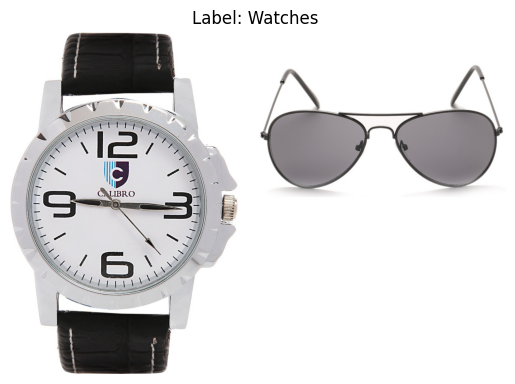

Product: Calibro SW-125 Analog-Digital Watch  - For Men, Boys
                         Price: Rs. 699
				
			CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.
CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by thi

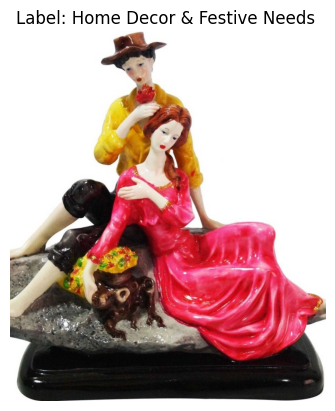

Product: Parv Collections Showpiece  -  12 cm (Polyresin, Multicolor)
                         Price: Rs. 1,085
				
			Lovely Sitting Couple Statue
Lovely Sitting Couple Statue
Label: Home Decor & Festive Needs 
Cleaned Description: parv collections showpiece cm polyresin multicolor price rs lovely sitting couple statue lovely sitting couple statue
Stemmed Description: parv collect showpiec cm polyresin multicolor price rs love sit coupl statu love sit coupl statu
Lemmatized Description: parv collection showpiece cm polyresin multicolor price r lovely sitting couple statue lovely sitting couple statue


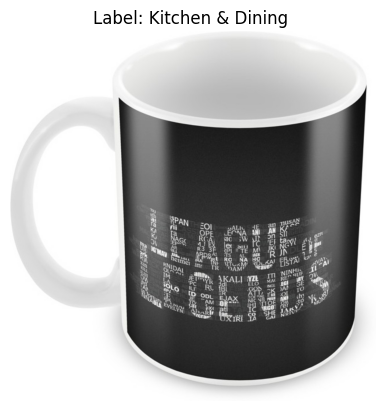

Product: Key Features of AKUP league-of-legends Ceramic Mug Pack of 1 Mug,AKUP league-of-legends Ceramic Mug (300 ml) Price: Rs. 259 AKUP Ceramic coffee mugs gives you the best quality printed mugs which you can gift to your loved ones. We provide good quality of products with packing. Coffee mugs made of ceramic clay with the volume capacity of 300ml each. You can buy it for yourself to make your moment unforgettable forever. Specifications Product Dimensions: Mugs - Height: 9.5 cms, Diameter: 8 cms. Item Type: Coffee Mug Color: Multi-Color Material: Clay Finish: Glossy Specialty: Lovely Style Wash care: Remove dirt by using a soft fabric to clean and then wipe with a moist cloth. Disclaimer: The fine design, pattern and color tone of the product may vary slightly from that shown in the image. However, there would not be any compromise in quality. Brand: AKUP designs & co,Specifications of AKUP league-of-legends Ceramic Mug (300 ml) General Type Mug Mug Capacity 300 ml Material Cerami

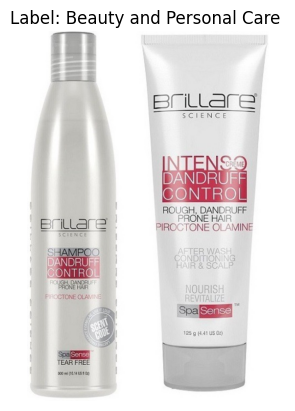

Product: Specifications of Brillare Science Dandruff Control Shampoo & Intenso Creme Combo (Set of) Combo Set Details Combo Set Contents 1 Dandruff Control Shampoo 150ml, 1 Dandruff Control Intenso Creme 125g Ideal For Women, Men Organic No General Traits Professional Care Yes
Label: Beauty and Personal Care 
Cleaned Description: specifications brillare science dandruff control shampoo intenso creme combo set combo set details combo set contents dandruff control shampoo ml dandruff control intenso creme g ideal women men organic general traits professional care yes
Stemmed Description: specif brillar scienc dandruff control shampoo intenso creme combo set combo set detail combo set content dandruff control shampoo ml dandruff control intenso creme g ideal women men organ gener trait profession care ye
Lemmatized Description: specification brillare science dandruff control shampoo intenso creme combo set combo set detail combo set content dandruff control shampoo ml dandruff control int

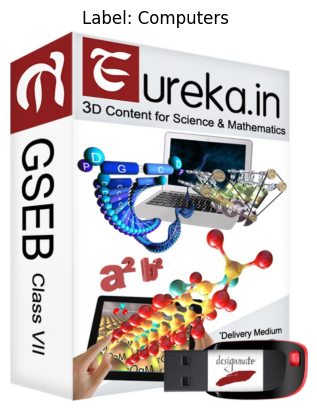

Product: Key Features of Product The graphically rich 3D audio-video captures complete attention which leads to a good understanding of the subject Concepts that are not understood through text are easily understood through videos Well-designed complete learning modules for each topic Student centric learning management software helps learner to improve his learning outcomes with least effort Complete and comprehensive curriculum coverage,Eureka.in GSEB Class VII (Pen drive) Price: Rs. 2,999 Our premium product, Eureka.in for class VII Science (GSEB board) offers high quality 3d learning content, will surely help students to improve their performance in exams. It will also help them to lay a solid foundation for future learning challenges.,Specification of Product General Subjects Science, Mathematics Brand Eureka.in Num Of Disks 1 Classes 7 Sales Package High quality 3d animated videos, Interactive 3d simulations, Script, Interactive learning quiz, Web links, Many other attractive fea

In [19]:
# Afficher une image pour chaque label possible
for label in data_text['label'].unique():
    row = data_text[data_text['label'] == label].iloc[5]  # Prendre la première occurrence pour chaque label
    display_info_and_image(row)


## Création des modèles

In [20]:
# Création du modèle Bag of Words pour les descriptions stemmées
descriptions_stemmed = data_text['stemmed_description']
vectorizer_stemmed = CountVectorizer()
vectorizer_stemmed.fit(descriptions_stemmed)
print("Vocabulaire (stemmed):", vectorizer_stemmed.vocabulary_)

# Création du modèle Bag of Words pour les descriptions lemmatizées
descriptions_lemmatized = data_text['lemmatized_description']
vectorizer_lemmatized = CountVectorizer()
vectorizer_lemmatized.fit(descriptions_lemmatized)
print("Vocabulaire (lemmatized):", vectorizer_lemmatized.vocabulary_)


# Création du modèle TF-IDF pour les descriptions lemmatizées
descriptions_lemmatized = data_text['lemmatized_description']
tfidf_vectorizer_lemmatized = TfidfVectorizer()
tfidf_vectorizer_lemmatized.fit(descriptions_lemmatized)
print("Vocabulaire TF-IDF (lemmatized):", tfidf_vectorizer_lemmatized.vocabulary_)

Vocabulaire (stemmed): {'key': 2149, 'featur': 1449, 'eleg': 1267, 'polyest': 3053, 'multicolor': 2626, 'abstract': 15, 'eyelet': 1395, 'door': 1148, 'curtain': 961, 'floral': 1528, 'curtaineleg': 962, 'cm': 743, 'height': 1849, 'pack': 2866, 'price': 3120, 'rs': 3439, 'enhanc': 1298, 'look': 2336, 'interiorsthi': 2046, 'made': 2389, 'high': 1865, 'qualiti': 3210, 'fabricit': 1404, 'style': 3894, 'stitch': 3851, 'metal': 2508, 'ringit': 3379, 'make': 2406, 'room': 3411, 'environ': 1316, 'romant': 3407, 'lovingthi': 2357, 'ant': 155, 'wrinkl': 4512, 'anti': 159, 'shrinkag': 3636, 'apparanceg': 181, 'home': 1892, 'bright': 486, 'modernist': 2566, 'appeal': 183, 'design': 1052, 'surreal': 3956, 'attent': 243, 'sure': 3948, 'steal': 3835, 'heart': 1841, 'contemporari': 850, 'valanc': 4276, 'slide': 3699, 'smoothli': 3723, 'draw': 1159, 'apart': 176, 'first': 1493, 'thing': 4079, 'morn': 2586, 'welcom': 4424, 'sun': 3920, 'ray': 3261, 'want': 4384, 'wish': 4472, 'good': 1719, 'whole': 4449,

## Création des vecteurs

### stemmed bow

In [21]:
# Transformer les descriptions en vecteurs
X_stemmed = vectorizer_stemmed.transform(descriptions_stemmed)

# Convertir en tableau
features_stemmed = X_stemmed.toarray()

# Afficher les vecteurs
print("Vecteurs (stemmed):", features_stemmed)


Vecteurs (stemmed): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### lemmatized bow

In [22]:
# Transformer les descriptions en vecteurs
X_lemmatized = vectorizer_lemmatized.transform(descriptions_lemmatized)

# Convertir en tableau
features_lemmatized = X_lemmatized.toarray()

# Afficher les vecteurs
print("Vecteurs (lemmatized):", features_lemmatized)

Vecteurs (lemmatized): [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### lemmatized tfidf

In [23]:
# Transformer les descriptions en vecteurs TF-IDF
X_tfidf_lemmatized = tfidf_vectorizer_lemmatized.transform(descriptions_lemmatized)

# Convertir en tableau
features_tfidf_lemmatized = X_tfidf_lemmatized.toarray()

# Afficher les vecteurs TF-IDF
print("Vecteurs TF-IDF (lemmatized):", features_tfidf_lemmatized)

Vecteurs TF-IDF (lemmatized): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Réduction dimension et analyse

### Réduction PCA

In [24]:
#bow_stem

# Initialisation de PCA pour features_stemmed
pca_stemmed = decomposition.PCA(n_components=0.99)

# Application de PCA sur features_stemmed
features_stemmed_pca = pca_stemmed.fit_transform(features_stemmed)

# Affichage des formes pour vérification
print("Shape des features_stemmed avant PCA:", features_stemmed.shape)

# Affichage des formes pour vérification
print("Shape des features_stemmed après PCA:", features_stemmed_pca.shape)



Shape des features_stemmed avant PCA: (1050, 4567)
Shape des features_stemmed après PCA: (1050, 576)


In [25]:
#bow_lem

# Initialisation de PCA pour features_lemmatized
pca_lemmatized = decomposition.PCA(n_components=0.99)

# Application de PCA sur features_lemmatized
features_lemmatized_pca = pca_lemmatized.fit_transform(features_lemmatized)

# Affichage des formes pour vérification
print("Shape des features_lemmatized avant PCA:", features_lemmatized.shape)

# Affichage des formes pour vérification
print("Shape des features_lemmatized après PCA:", features_lemmatized_pca.shape)


Shape des features_lemmatized avant PCA: (1050, 5128)
Shape des features_lemmatized après PCA: (1050, 584)


In [26]:
#tfidf

# Initialisation de PCA pour features_tfidf_lemmatized
pca_tfidf_lemmatized = decomposition.PCA(n_components=0.99)

# Application de PCA sur features_tfidf_lemmatized
features_tfidf_lemmatized_pca = pca_tfidf_lemmatized.fit_transform(features_tfidf_lemmatized)

# Affichage des formes pour vérification
print("Shape des features_tfidf_lemmatized avant PCA:", features_tfidf_lemmatized.shape)

# Affichage des formes pour vérification
print("Shape des features_tfidf_lemmatized après PCA:", features_tfidf_lemmatized_pca.shape)


Shape des features_tfidf_lemmatized avant PCA: (1050, 5128)
Shape des features_tfidf_lemmatized après PCA: (1050, 826)


### Réduction de dimension T-SNE et affichage des items selon vraies classes

In [27]:
#bow_stem

# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_stemmed = tsne.fit_transform(features_stemmed_pca)

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données après T-SNE:", X_tsne_stemmed.shape)


temps de T-SNE :             2.38 secondes
Shape des données après T-SNE: (1050, 2)


In [28]:
#bow_lem

# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_lemmatized = tsne.fit_transform(features_lemmatized_pca)

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données après T-SNE:", X_tsne_lemmatized.shape)


temps de T-SNE :             2.53 secondes
Shape des données après T-SNE: (1050, 2)


In [29]:
#tfidf

# Heure de début de l'exécution de T-SNE
temps1 = time.time()

# Exécution de T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
# Application de T-SNE sur les données PCA pour obtenir la représentation en 2D
X_tsne_tfidf_lemmatized = tsne.fit_transform(features_tfidf_lemmatized_pca)

# Heure de fin de l'exécution et calcul du temps d'exécution
duration1 = time.time() - temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

# Affichage de la forme des données après T-SNE pour vérification
print("Shape des données après T-SNE:", X_tsne_tfidf_lemmatized.shape)


temps de T-SNE :             2.29 secondes
Shape des données après T-SNE: (1050, 2)


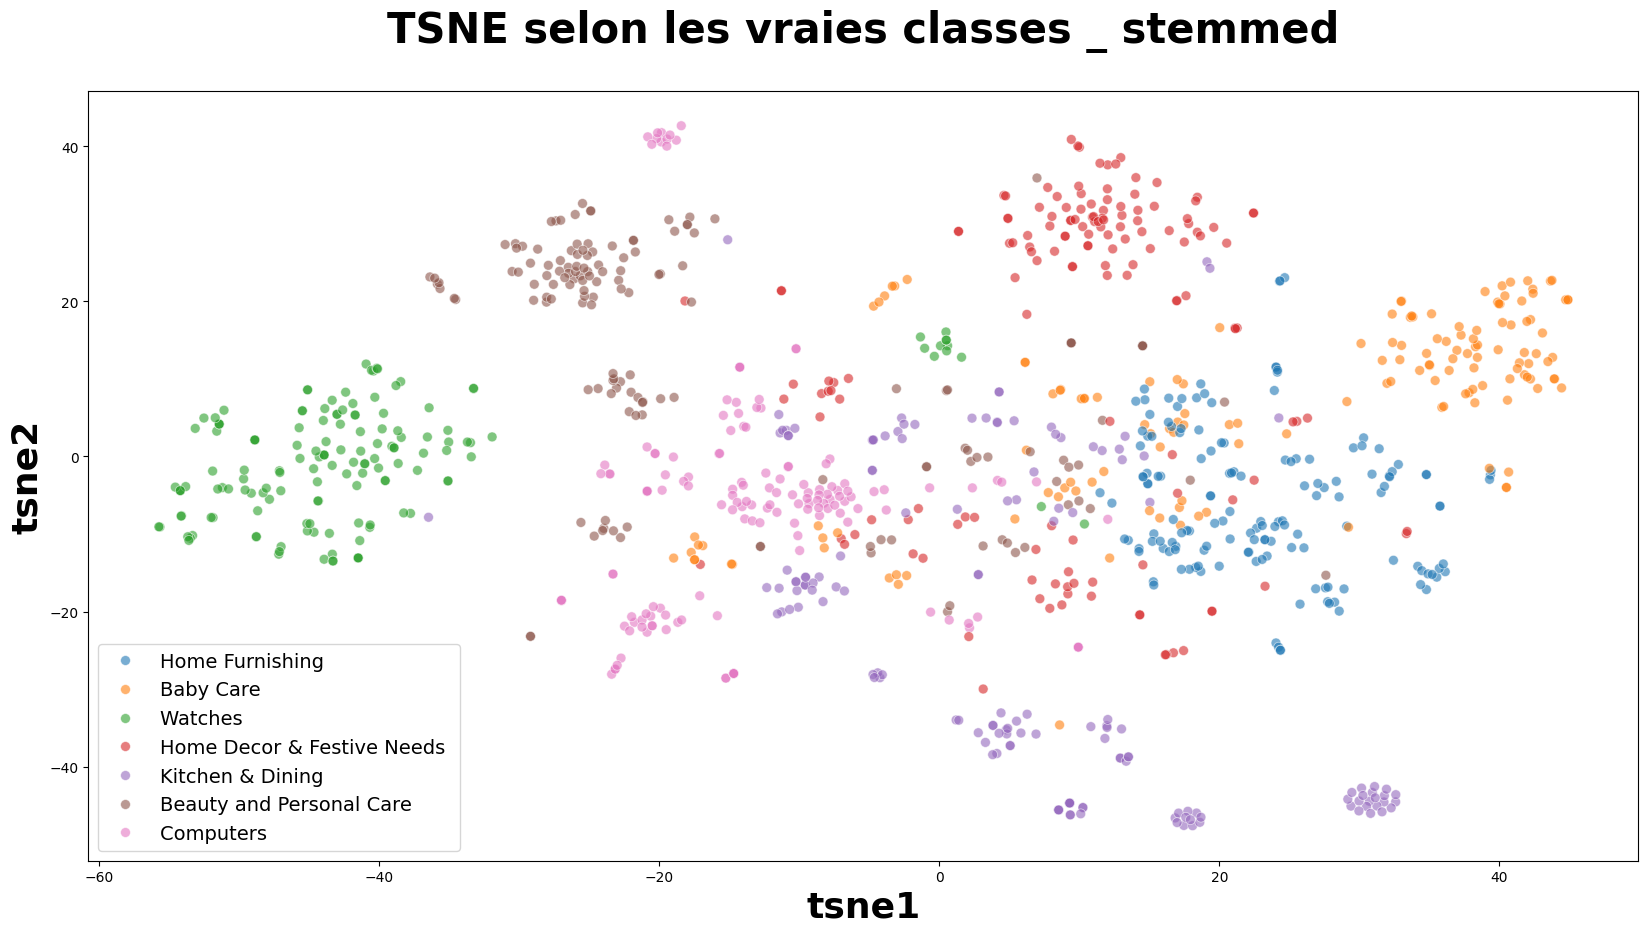

In [30]:
#bow_stem

# création dataframe pour affichage avec coordonnées tsne
df_tsne1 = pd.DataFrame(X_tsne_stemmed, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne1["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(20,10))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne1, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ stemmed', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


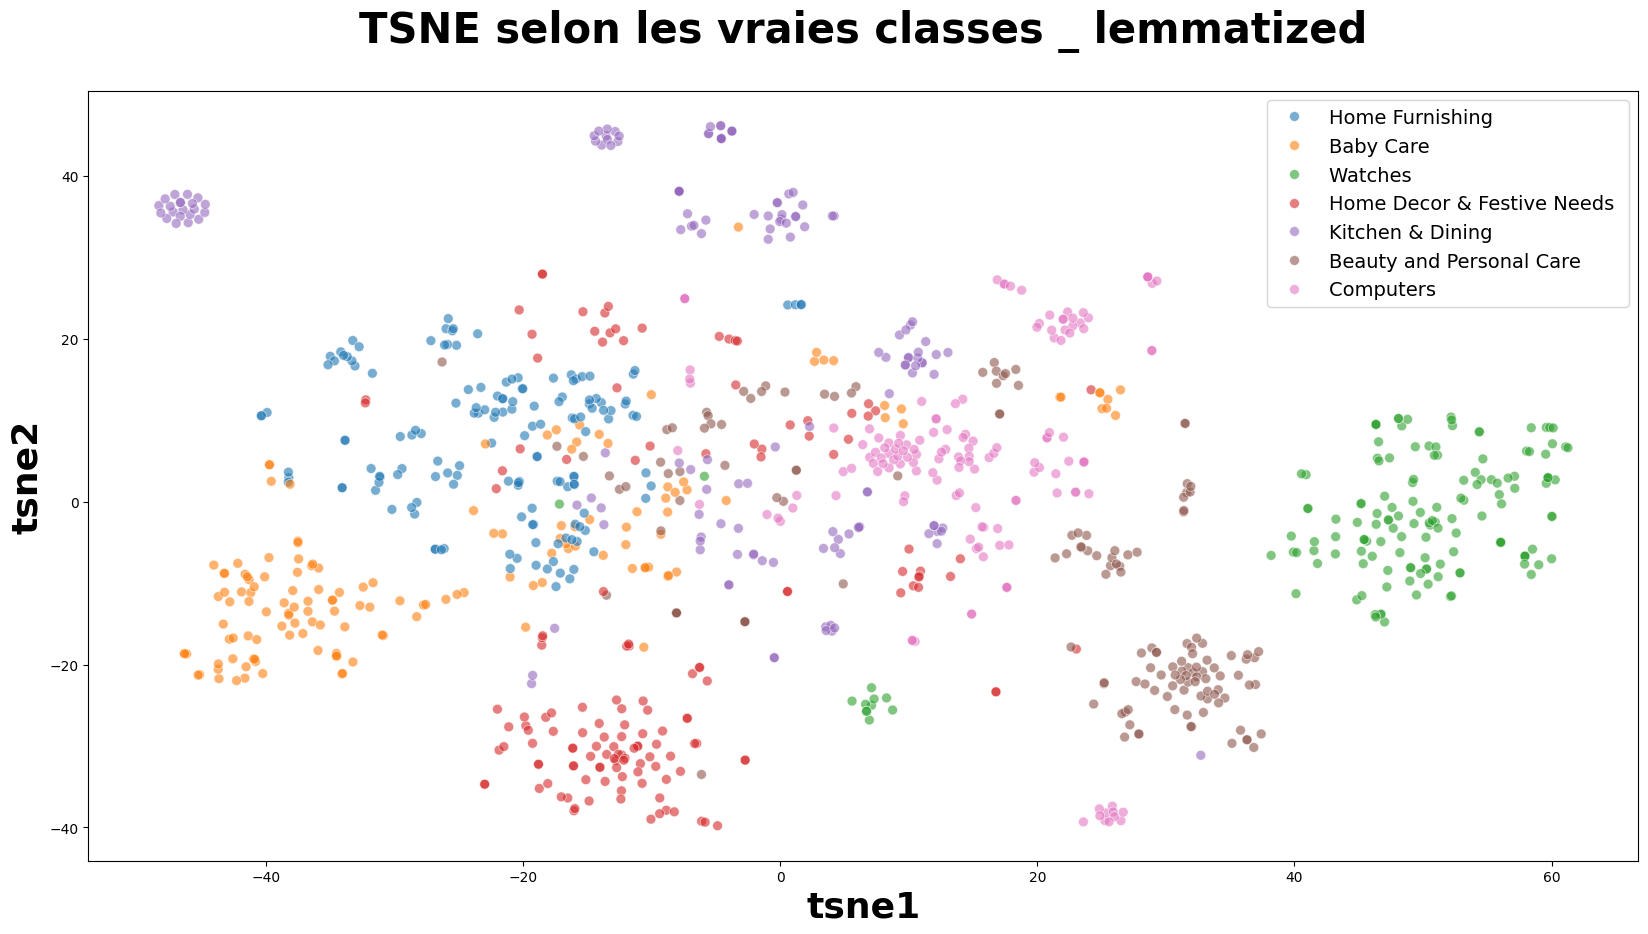

In [31]:
#bow_lem

# création dataframe pour affichage avec coordonnées tsne
df_tsne2 = pd.DataFrame(X_tsne_lemmatized, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne2["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(20,10))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne2, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ lemmatized', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


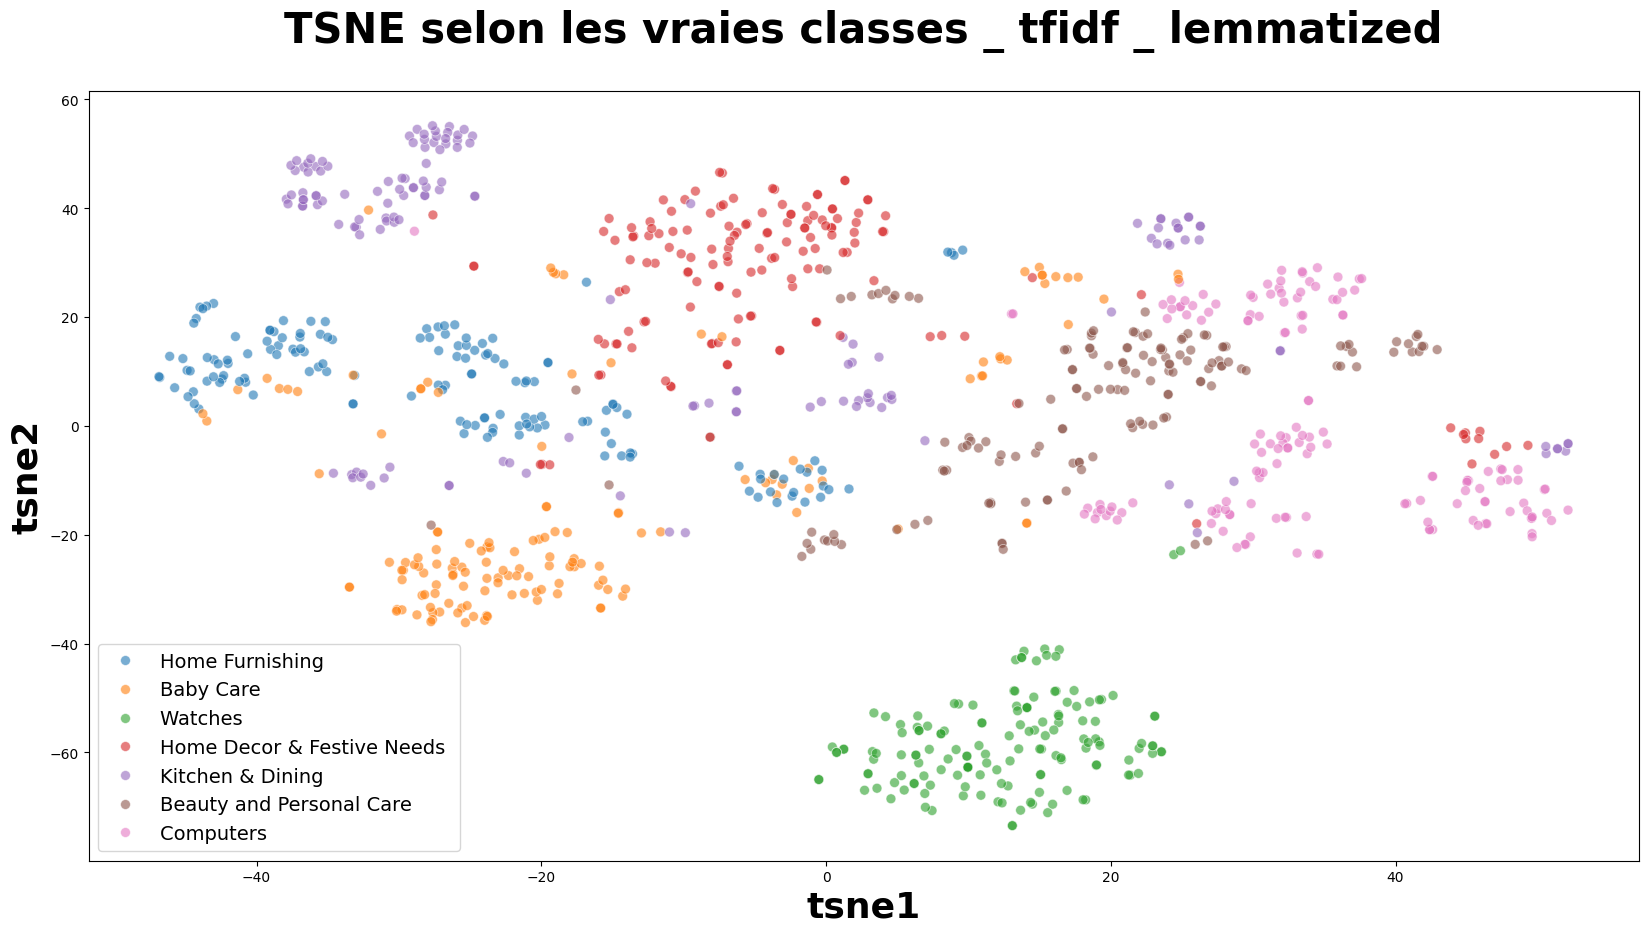

In [32]:
#tfidf

# création dataframe pour affichage avec coordonnées tsne
df_tsne3 = pd.DataFrame(X_tsne_tfidf_lemmatized, columns=['tsne1', 'tsne2'])
# ajout colonne pour etiquette
df_tsne3["class"] = data_text["label"]

# configuration figure
plt.figure(figsize=(20,10))

# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2",# définition des colonnes à utiliser pour les axes
    hue="class", # coloriage des points selon class
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette avec 4 couleurs, points de taille 50, 0.6 de transparence
    data=df_tsne3, # source des données
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les vraies classes _ tfidf _ lemmatized', fontsize = 30, pad = 35, fontweight = 'bold') # titre du graphique, paramètres de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # label axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # label axe y
plt.legend(prop={'size': 14}) # style légende

# affichage graphique
plt.show()


### Création de clusters à partir du T-SNE et affichage des items selon clusters


In [33]:
#bow_lem

# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (4 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls = cluster.KMeans(n_clusters=7, n_init=100)
# application kmeans aux données tSNE
cls.fit(X_tsne_lemmatized)

KMeans(n_clusters=7, n_init=100)

In [34]:
#bow_lem

# import module clustering et métriques
from sklearn import cluster, metrics

# config module cls (4 clusters, et 100 fois avec centroides initiaux diff, recherche celui avec meilleure inertie)
cls_tfidf = cluster.KMeans(n_clusters=7, n_init=100)
# application kmeans aux données tSNE
cls_tfidf.fit(X_tsne_tfidf_lemmatized)

KMeans(n_clusters=7, n_init=100)

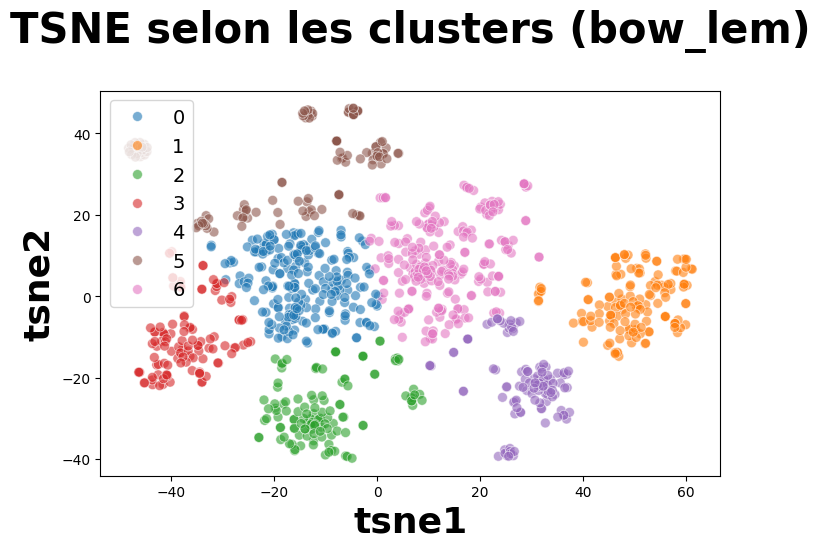

ARI (bow_lem) :  0.4010731812844012


In [35]:
#Visualisation des clusters
df_tsne2["cluster"] = cls.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne2, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (bow_lem)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (bow_lem) : ", metrics.adjusted_rand_score(labels, cls.labels_))

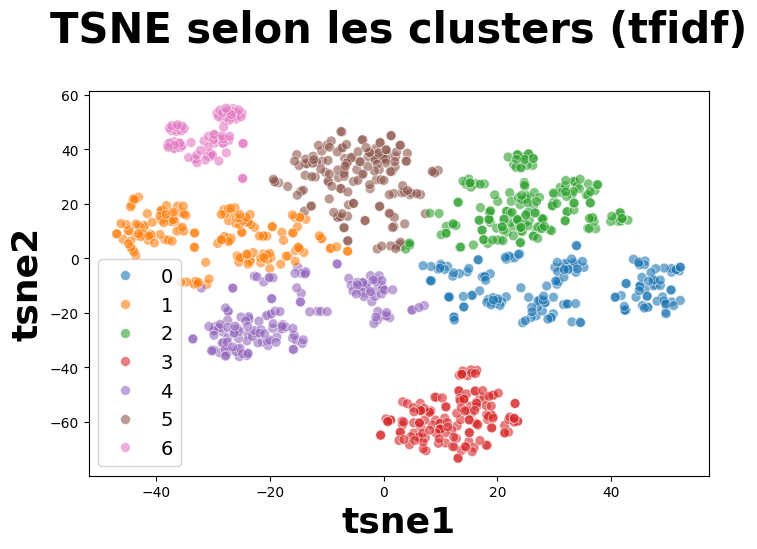

ARI (tfidf):  0.4848144600991312


In [36]:
#Visualisation des clusters
df_tsne3["cluster"] = cls_tfidf.labels_ # ajout etiquettes

# config figure
plt.figure(figsize=(8,5))
# création graphique de dispersion
sns.scatterplot(
    x="tsne1", y="tsne2", # selection des données pour axes x et y
    hue="cluster", # coloriage des points en fonction cluter
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6, # palette 7 couleurs, , points taille 50, transparence 0.6
    data=df_tsne3, # source des données pour graph
    legend="brief") # légende succinte

# titres et labels
plt.title('TSNE selon les clusters (tfidf)', fontsize = 30, pad = 35, fontweight = 'bold') # titre, paramètre de style
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold') # axe x
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') # axe y
plt.legend(prop={'size': 14})  # style légende

# affichage graphique
plt.show()

# évaluation clustering
labels = data_text["label"]
print("ARI (tfidf): ", metrics.adjusted_rand_score(labels, cls_tfidf.labels_))

### Analyse par classes bow

In [37]:
# Encodage des labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# mAtrice de confusion
conf_mat = metrics.confusion_matrix(labels_encoded, cls.labels_) # calcul la matrice de confusion
print(conf_mat)# affichage matrice de confusion

[[ 42   0   2  88   0   1  17]
 [ 23   7   7   0  86   1  26]
 [  8   0   0   0  19   3 120]
 [ 15   0  94   0   3  18  20]
 [102   0   0  24   0  20   4]
 [ 24   0  10   0   1  74  41]
 [  2 138  10   0   0   0   0]]


In [38]:
# transformation de la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred) # calcul de la matrice de confusion
    
    corresp = np.argmax(conf_mat, axis=0) # trouve la correspondance des clusters
    print ("Correspondance des clusters : ", corresp)# affiche la correspondance
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame() # création d'un dataframe avec etiquettes reelles
    labels['y_pred'] = y_pred # ajoute etiquettes predites
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) # transforme etiquettes predites avec correspondance trouvée
    
    return labels['y_pred_transform'] # renvoie les etiquettes transformées

In [39]:
# application de la transformation et evaluation
cls_labels_transform = conf_mat_transform(labels_encoded, cls.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat = metrics.confusion_matrix(labels_encoded, cls_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat) # affiche la matrice de confusion
print()
print(metrics.classification_report(labels_encoded, cls_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [4 6 3 0 1 5 2]
[[ 88   0  17   2  42   1   0]
 [  0  86  26   7  23   1   7]
 [  0  19 120   0   8   3   0]
 [  0   3  20  94  15  18   0]
 [ 24   0   4   0 102  20   0]
 [  0   1  41  10  24  74   0]
 [  0   0   0  10   2   0 138]]

              precision    recall  f1-score   support

           0       0.79      0.59      0.67       150
           1       0.79      0.57      0.66       150
           2       0.53      0.80      0.63       150
           3       0.76      0.63      0.69       150
           4       0.47      0.68      0.56       150
           5       0.63      0.49      0.55       150
           6       0.95      0.92      0.94       150

    accuracy                           0.67      1050
   macro avg       0.70      0.67      0.67      1050
weighted avg       0.70      0.67      0.67      1050



<Axes: >

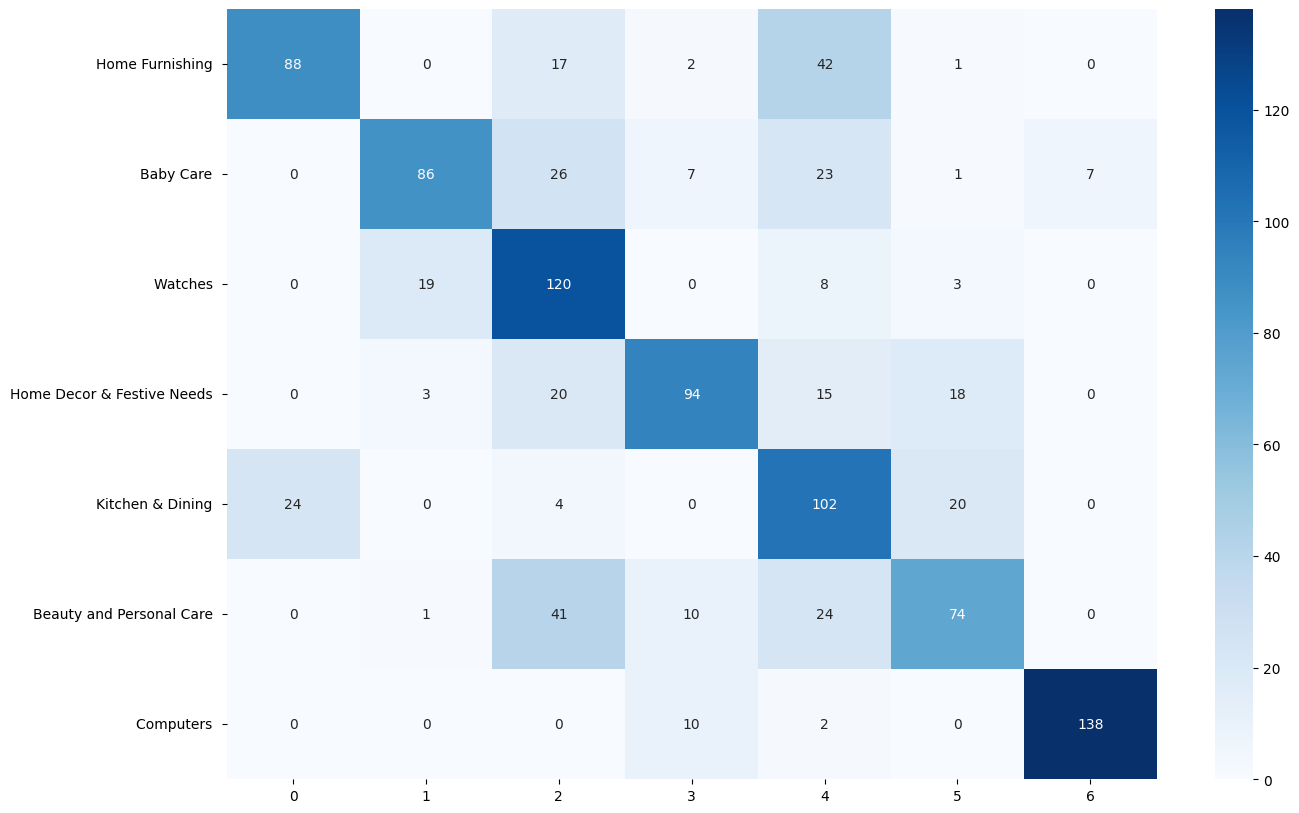

In [40]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (15,10)) # configuration de la taille de la figure
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap

###  Analyse par classes tfidf

In [41]:
# Encodage des labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# mAtrice de confusion
conf_mat_tfidf = metrics.confusion_matrix(labels_encoded, cls_tfidf.labels_) # calcul la matrice de confusion
print(conf_mat_tfidf)# affichage matrice de confusion

[[  2  17  19   0 105   6   1]
 [ 41   1  83   0  15  10   0]
 [ 99   0  50   0   0   0   1]
 [ 11  10   5   0   4 117   3]
 [  0 119   0   0  26   5   0]
 [ 12  14  24   0   9  17  74]
 [  2   0   0 148   0   0   0]]


In [42]:
# application de la transformation et evaluation
cls_tfidf_labels_transform = conf_mat_transform(labels_encoded, cls_tfidf.labels_) # applique la fonction de transformation aux etiquettes des clusters
conf_mat_tfidf = metrics.confusion_matrix(labels_encoded, cls_tfidf_labels_transform) # calcule la nouvelle matrice de confustion avec les etiquettes transformées
print(conf_mat_tfidf) # affiche la matrice de confusion
print()
print(metrics.classification_report(labels_encoded, cls_tfidf_labels_transform)) # affiche rapport de classification détaillé (avec précision, rappel et score F1 pour chaque classe)

Correspondance des clusters :  [2 4 1 6 0 3 5]
[[105  19   2   6  17   1   0]
 [ 15  83  41  10   1   0   0]
 [  0  50  99   0   0   1   0]
 [  4   5  11 117  10   3   0]
 [ 26   0   0   5 119   0   0]
 [  9  24  12  17  14  74   0]
 [  0   0   2   0   0   0 148]]

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       150
           1       0.46      0.55      0.50       150
           2       0.59      0.66      0.62       150
           3       0.75      0.78      0.77       150
           4       0.74      0.79      0.77       150
           5       0.94      0.49      0.65       150
           6       1.00      0.99      0.99       150

    accuracy                           0.71      1050
   macro avg       0.73      0.71      0.71      1050
weighted avg       0.73      0.71      0.71      1050



<Axes: >

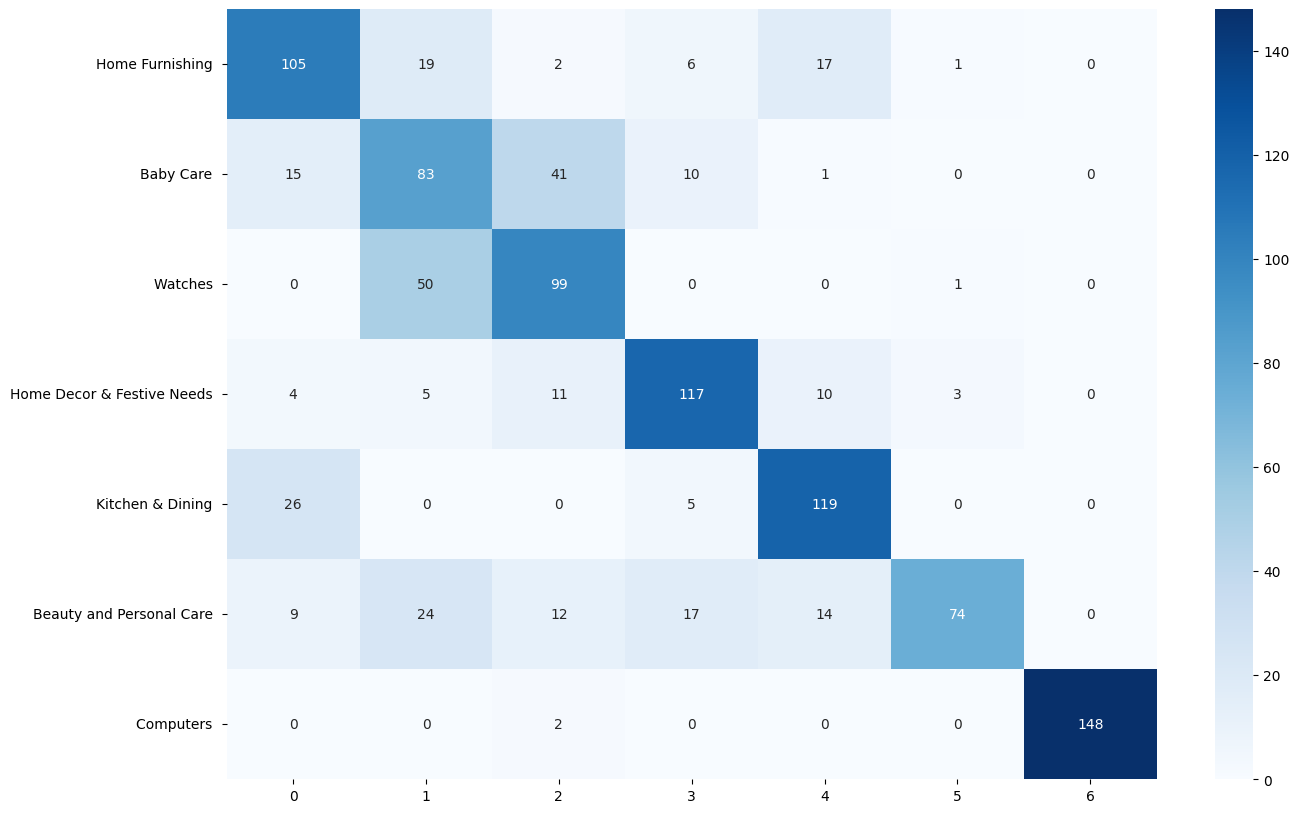

In [43]:
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers ']

df_tfidf_cm = pd.DataFrame(conf_mat_tfidf, index = [label for label in list_labels],
                  columns = [i for i in "0123456"]) # création dataframe a partir matrice conf avec labels en index et les colonnes
plt.figure(figsize = (15,10)) # configuration de la taille de la figure
sns.heatmap(df_tfidf_cm, annot=True, cmap="Blues", fmt='d') # créé une jolie heatmap